In [3]:
import sys
import glob
from pathlib import Path

config_path = Path('../../Sign-Language-Translator-(DL)')
sys.path.append(str(config_path))

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy
from torchvision.transforms import v2, functional

import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
BASE_PATH = '..\\'

ASSETS_PATH = os.path.join(BASE_PATH, 'Assets')
DATASET_PATH = os.path.join(ASSETS_PATH, 'Datasets', 'SIBI dataset')

FILE_TRAINING_PATH = os.path.join(DATASET_PATH, 'Train', '*', '*')
LABEL_TRAINING_PATH = os.path.join(DATASET_PATH, 'Train', '*')

In [7]:
list_files_path = glob.glob(FILE_TRAINING_PATH)
label_paths = glob.glob(LABEL_TRAINING_PATH)

In [8]:
class_lists = [os.path.basename(path) for path in label_paths]

In [9]:
print(class_lists)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [37]:
get_random_idx = np.random.randint(len(list_files_path))
get_data_path = list_files_path[get_random_idx]
split_file_path = get_data_path.split(os.path.sep)
kind_data = split_file_path[-3]
file_path_index = {value: f'Index -> {index}' for index, value in enumerate(split_file_path)}
index_kind_data = np.where(np.equal(split_file_path, kind_data))[0][0]
index_label = index_kind_data + 1
file_name = split_file_path[-1]
file_extension = os.path.splitext(file_name)[1]
file_size = os.path.getsize(get_data_path)

print('=' * 60)
print(' PATH INFO '.center(60, '='))
print('=' * 60)
print(f'File Path: {get_data_path}')
print('=' * 60)
print()

print('=' * 60)
print(' SPLIT FILE PATH '.center(60, '='))
print('=' * 60)
print(f'Split File Path: {split_file_path}')
print('=' * 60)
print()

print('=' * 60)
print(' INDEXED PATH '.center(60, '='))
print('=' * 60)
for key, value in file_path_index.items():
    print(f'{value}: {key}')
print('=' * 60)
print()

print('=' * 60)
print(f' KIND DATA INDEX: {kind_data} '.center(60, '='))
print('=' * 60)
print(f'Index of "{kind_data}": {index_kind_data}')
print('=' * 60)
print()

print('=' * 60)
print(' INDEX LABEL '.center(60, '='))
print('=' * 60)
print(f'Index Label: {index_label}')
print('=' * 60)
print()

print('=' * 60)
print(' LABEL '.center(60, '='))
print('=' * 60)
print(f'Label: {split_file_path[index_label]}')
print('=' * 60)
print()

print('=' * 60)
print(' FILE NAME '.center(60, '='))
print('=' * 60)
print(f'File Name: {file_name}')
print('=' * 60)
print()

print('=' * 60)
print(' FILE EXTENSION '.center(60, '='))
print('=' * 60)
print(f'File Extension: {file_extension}')
print('=' * 60)
print()

print('=' * 60)
print(' FILE SIZE '.center(60, '='))
print('=' * 60)
print(f'File Size: {np.round(file_size / 1024, 4)} kb')
print('=' * 60)
print()

======================== PATH INFO =========================
File Path: ..\Assets\Datasets\SIBI dataset\Train\M\image_M_(1723070619.9711719).jpg

===================== SPLIT FILE PATH ======================
Split File Path: ['..', 'Assets', 'Datasets', 'SIBI dataset', 'Train', 'M', 'image_M_(1723070619.9711719).jpg']

======================= INDEXED PATH =======================
Index -> 0: ..
Index -> 1: Assets
Index -> 2: Datasets
Index -> 3: SIBI dataset
Index -> 4: Train
Index -> 5: M
Index -> 6: image_M_(1723070619.9711719).jpg

================== KIND DATA INDEX: Train ==================
Index of "Train": 4

======================= INDEX LABEL ========================
Index Label: 5

========================== LABEL ===========================
Label: M

======================== FILE NAME =========================
File Name: image_M_(1723070619.9711719).jpg

====================== FILE EXTENSION ======================
File Extension: .jpg

======================== FILE SIZE =======

In [58]:
class ImagePathDataset(Dataset):
    def __init__(self, file_paths, image_cvt_to_gray=False):
        self.file_paths = file_paths
        self.image_cvt_to_gray = image_cvt_to_gray
    
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        file_path_split = file_path.split(os.path.sep)
        label = np.array(file_path_split[-2])
        
        image = cv2.imread(file_path)

        if self.image_cvt_to_gray:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            image = np.expand_dims(image, -1)
        else:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        return image, label

In [59]:
class ABC_CLASS_1(Dataset):
    def __init__(self, torch_dataset, transform_image, transform_label):
        self.torch_dataset = torch_dataset
        self.transform_image = transform_image
        self.transform_label = transform_label
    
    def __len__(self):
        return len(self.torch_dataset)

    def __getitem__(self, idx):
        image, label = self.torch_dataset[idx]
        image = self.transform_image(image)
        label = self.transform_label(label)
        return image, label

In [60]:
torch_dataset = ImagePathDataset(list_files_path, image_cvt_to_gray=True)

Check Train Data
    shape-image: (224, 224, 1)
    dtype-image: uint8
    max-intensity: 255
    min-intensity: 0

    label: F
    label-shape: ()
    image-type: <U1


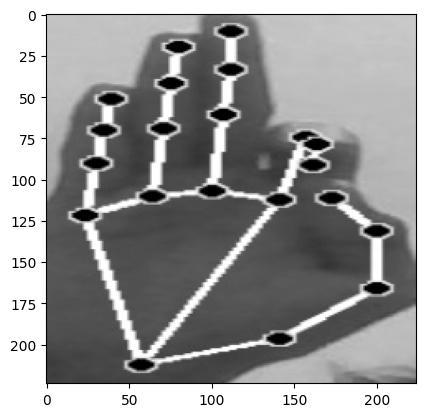

In [61]:
image, label = torch_dataset[1000]
print(f"{'Check Train Data'.center(10, '=')}", end='')
print(f'''
    shape-image: {image.shape}
    dtype-image: {image.dtype}
    max-intensity: {image.max()}
    min-intensity: {image.min()}

    label: {label}
    label-shape: {label.shape}
    image-type: {label.dtype}'''
)

plt.imshow(image, cmap='gray')
plt.show()

In [62]:
class ToOneHotEncoding(object):
    def __init__(self, class_lists):
        self.class_lists = class_lists

    def __call__(self, label):
        label_to_index_func = self.__label_to_index()
        label_str = str(label)
        label = torch.tensor(label_to_index_func[label_str.upper()])
        label = F.one_hot(label, num_classes=len(self.class_lists))
        return label
    
    def __label_to_index(self):
        label_to_index = {value:index for index, value in enumerate(self.class_lists)}
        return label_to_index

In [68]:
train_image_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_label_transform = v2.Compose([
    ToOneHotEncoding(class_lists),
    v2.ToDtype(torch.float32)
])

In [69]:
torch_image_transform = ABC_CLASS_1(torch_dataset, train_image_transform, train_label_transform)

In [70]:
len(torch_image_transform)

5200

Check Train Data
    image-shape: torch.Size([1, 224, 224])
    image-dtype: torch.float32
    max-intensity: 1.0
    min-intensity: 0.0

    label: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
    label-shape: torch.Size([26])
    label-dtype: torch.float32


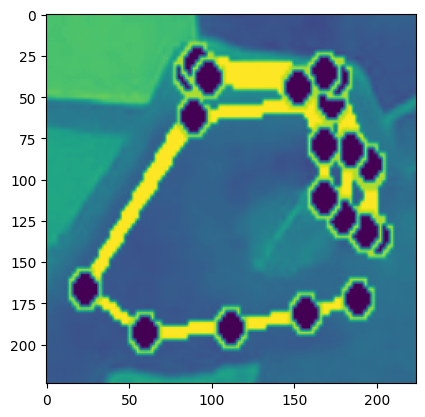

In [71]:
random_index = np.random.randint(len(torch_image_transform))
image, label = torch_image_transform[random_index]
image_plot = np.array(functional.to_pil_image(image))

print(f"{'Check Train Data'.center(10, '=')}", end='')
print(f'''
    image-shape: {image.shape}
    image-dtype: {image.dtype}
    max-intensity: {image.max()}
    min-intensity: {image.min()}

    label: {label}
    label-shape: {label.shape}
    label-dtype: {label.dtype}'''
)

plt.imshow(image_plot)
plt.show()